In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import itertools
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
models = list(zip(
    [
        "Logistic Regression", 
        "SVC (Linear)", 
        "SVC (RBF)", 
        "Random Forest"
    ],
    [
        LogisticRegression(solver = 'saga', fit_intercept = True, random_state = 42, n_jobs = 1),
        SVC(kernel = "linear", random_state = 42),
        SVC(kernel = "rbf", random_state = 42),
        RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = 1)
    ]
))

In [3]:
from load_adult import EXPORTED_DATASET
preprocess_dataset, dataset, Y_VAR = EXPORTED_DATASET
preprop = preprocess_dataset(dataset)

/home/koppd/.conda/envs/tf2/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


# Goals

- Test causal relationships to infer predictivity of variables
- Test variable ordinal ordering to find
    1. Maximially suboptimial ordering
    2. Random orderings
    3. Optimal orderings


4 Phases

1 phase per day


Today we will implement the maximally suboptimal ordering

In [4]:
y_data = preprop[0][Y_VAR]


def reorder(input_data, ordering):
    mapping = {x: y for x, y in enumerate(ordering)}
    return np.vectorize(lambda x: mapping[x])(input_data)

def test_all_permutations(feature, goal, model, trials=None):
    default_label_encoded = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int)
    all_labels = list(range(np.max(default_label_encoded) + 1))

    
    data = []
    
    
    def run_trial(p):
        ordered_data = reorder(default_label_encoded, p)
        
        X_train, X_test, y_train, y_test = train_test_split(ordered_data, y_data, test_size=0.3)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        score = goal(y_test, y_pred)
        data.append({
            "permutation": p,
            "score": score
        })
    
    if trials != None:
        for _ in range(trials):
            p = np.random.permutation(all_labels)
            run_trial(p)
    else:
        for p in itertools.permutations(all_labels):
            run_trial(p)
        
        
        
    return pd.DataFrame(data)


    

In [5]:
# def plot_permutation(feature, permutation):
#     default_label_encoded = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int).flatten()
#     x = reorder(default_label_encoded, permutation)
#     # plt.scatter(x, y_data)
#     data = pd.DataFrame({
#         "x": x,
#         "y": y_data
#     })
    
#     model = LogisticRegression().fit(x.reshape(-1,1), y_data)
    
#     b = model.intercept_[0]
#     w = model.coef_.T
    
#     # plot rates for each class
#     rates = []
#     classes = []
#     for c in data["x"].unique():
#         classes.append(c)
#         rates.append(np.mean(y_data[x == c]))
#         # print(c, np.mean(y_data[x == c]))
        
#     plt.scatter(classes, rates)
    
#     # sns.violinplot(data, x="x", y="y")
#     # plt.xticks(labels=permutation)
#     plt.plot(np.repeat([-b/w], 10), np.linspace(0, 1, 10))
#     plt.plot(np.linspace(0, max(classes), 10), np.repeat([0.5], 10))
#     plt.show()


In [6]:
def inverse_perm(p):
    return np.arange(len(p))[np.argsort(p)]

def reorder(input_data, ordering):
    mapping = {x: y for x, y in enumerate(ordering)}
    return np.vectorize(lambda x: mapping[x])(input_data)

def target_encode(feature, train_index):
    x = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int).flatten()
    rates = []
    classes = []
    for c in np.unique(x):
        classes.append(c)
        mask = x == c
        filtered_train = train_index[mask[train_index]]
        rates.append(np.mean(y_data[filtered_train]))
        
    rates = np.nan_to_num(rates)
    
              
    return reorder(
        x,
        inverse_perm(np.array(classes)[np.argsort(rates)])
    )
    


def random_encode(feature, _):
    x = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int).flatten()
    return reorder(
        x,
        np.random.permutation(np.max(x) + 1)
    )    
    


In [7]:
def train_test(one_hot_vars, label_vars, train_index=None, test_index=None):
    Y = preprop[0][Y_VAR]

    if len(one_hot_vars) > 0:
        X = preprop[0][np.concatenate([preprop[1][feature] for feature in one_hot_vars])]
    else:
        X = None
        
    for feature in label_vars:
        if X is not None:
            X.loc[:,feature] = preprop[2][feature].copy()
        else:
            X = pd.DataFrame({feature: preprop[2][feature].copy()})
    
    if train_index is None or test_index is None:
        return train_test_split(X.values, Y.values, test_size=0.3)
    xv, yv = X.values, Y.values
    return xv[train_index], xv[test_index], yv[train_index], yv[test_index]

def label_vs_onehot(one_hot_vars, label_vars, N_trials=20):
    X_train, X_test, y_train, y_test = train_test(one_hot_vars, label_vars)
    # ros = RandomOverSampler(sampling_strategy='minority')
    scores = []
    # for _ in range(N_trials):
        # model = LogisticRegression().fit(*ros.fit_resample(X_train, y_train))
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(balanced_accuracy_score(y_test, y_pred))
        
    print("OneHot:", one_hot_vars, "| Label:", label_vars, "|", np.mean(score))#, np.std(score) / N_trials)
    return scores[0]
    

In [8]:
feature_subset = [
    "age", 
    "race", 
    # "gender", 
    "native-country", 
    "hours-per-week", 
    "workclass", 
    "education", 
    "marital-status", 
    "occupation", 
    "relationship"
]


# X = dataset[feature_subset]
# y = dataset[Y_VAR]
X,_,y,_ = train_test([], feature_subset)

model = CatBoostClassifier()
model.fit(X, y)

importances = model.get_feature_importance(prettified=True)
importances


Learning rate set to 0.045043
0:	learn: 0.6552321	total: 75.1ms	remaining: 1m 15s
1:	learn: 0.6218673	total: 89.5ms	remaining: 44.7s
2:	learn: 0.5941886	total: 102ms	remaining: 33.8s
3:	learn: 0.5715682	total: 115ms	remaining: 28.5s
4:	learn: 0.5502171	total: 125ms	remaining: 24.8s
5:	learn: 0.5323699	total: 134ms	remaining: 22.3s
6:	learn: 0.5153689	total: 144ms	remaining: 20.4s
7:	learn: 0.5007646	total: 153ms	remaining: 19s
8:	learn: 0.4875529	total: 167ms	remaining: 18.4s
9:	learn: 0.4765094	total: 176ms	remaining: 17.4s
10:	learn: 0.4673150	total: 182ms	remaining: 16.4s
11:	learn: 0.4590559	total: 188ms	remaining: 15.4s
12:	learn: 0.4510504	total: 194ms	remaining: 14.7s
13:	learn: 0.4440087	total: 200ms	remaining: 14.1s
14:	learn: 0.4376599	total: 206ms	remaining: 13.5s
15:	learn: 0.4316351	total: 212ms	remaining: 13s
16:	learn: 0.4261991	total: 217ms	remaining: 12.5s
17:	learn: 0.4214581	total: 228ms	remaining: 12.4s
18:	learn: 0.4172644	total: 234ms	remaining: 12.1s
19:	learn: 0

,Feature Id,Importances
0,8,21.958345
1,5,18.293312
2,7,17.436168
3,0,15.424268
4,3,9.750211
5,6,7.378337
6,4,4.698811
7,2,2.760742
8,1,2.299805


In [10]:
sorted_vars = [feature_subset[int(feature)] for feature, _ in importances.values]
sorted_vars

['relationship',
 'education',
 'occupation',
 'age',
 'hours-per-week',
 'marital-status',
 'workclass',
 'native-country',
 'race']

In [9]:
data = []

models = list(zip(
    [
        "Logistic Regression", 
        "SVC (Linear)", 
        "SVC (RBF)", 
        "Random Forest"
    ],
    [
        LogisticRegression(solver = 'saga', fit_intercept = True, random_state = 42, n_jobs = 1),
        SVC(kernel = "linear", random_state = 42),
        SVC(kernel = "rbf", random_state = 42),
        RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = 1)
    ]
))

train_index, test_index = train_test_split(np.arange(len(dataset)))

for oh in range(2):
    # for index in range(len(sorted_vars) + 1):
    # one_hot_vars = sorted_vars[index:] # start with all 
    # label_vars = sorted_vars[:index]
    if oh == 0:
        X_train, X_test, y_train, y_test = train_test([], sorted_vars, train_index=train_index, test_index=test_index)
    else:
        X_train, X_test, y_train, y_test = train_test(sorted_vars, [], train_index=train_index, test_index=test_index)
        
    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = balanced_accuracy_score(y_test, y_pred)
        print(oh, model_name, score)
        data.append({
            "model": model_name,
            # "index": index,
            "bal_acc": score,
            "oh": "one_hot" if oh == 1 else "label"
        })
        
whole_encoding = pd.DataFrame(data)

whole_encoding

0 Logistic Regression 0.5941815521842926
0 SVC (Linear) 0.5
0 SVC (RBF) 0.7161196789970279
0 Random Forest 0.7252254235165068
1 Logistic Regression 0.7394393993108292
1 SVC (Linear) 0.7388287568535497
1 SVC (RBF) 0.722446825160019
1 Random Forest 0.7250140583784082


,model,bal_acc,oh
0,Logistic Regression,0.594182,label
1,SVC (Linear),0.500000,label
2,SVC (RBF),0.716120,label
3,Random Forest,0.725225,label
4,Logistic Regression,0.739439,one_hot
5,SVC (Linear),0.738829,one_hot
6,SVC (RBF),0.722447,one_hot
7,Random Forest,0.725014,one_hot


In [10]:
whole_encoding.to_csv('whole_encoding.csv')

Text(0.5, 36.58159722222221, 'Encoding Type')

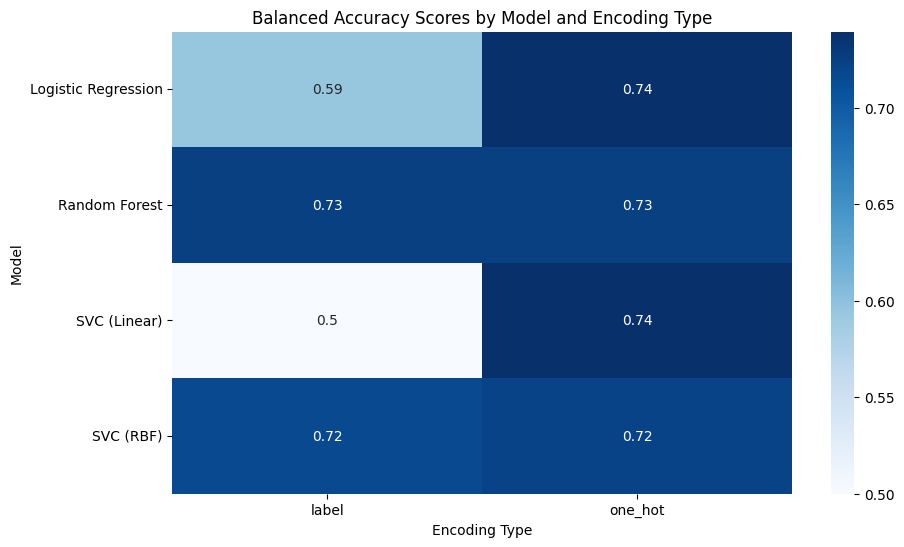

In [16]:
# Reshaping the DataFrame for the heatmap
heatmap_data = whole_encoding.pivot("model", "oh", "bal_acc")

# Creating the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

# Adding titles and labels
plt.title('Balanced Accuracy Scores by Model and Encoding Type')
plt.ylabel('Model')
plt.xlabel('Encoding Type')

In [10]:
len(sorted_vars)

9

In [11]:
data = []

models = list(zip(
    [
        "Logistic Regression", 
        "SVC (Linear)", 
        "SVC (RBF)", 
        "Random Forest"
    ],
    [
        LogisticRegression(solver = 'saga', fit_intercept = True, random_state = 42, n_jobs = 1),
        SVC(kernel = "linear", random_state = 42),
        SVC(kernel = "rbf", random_state = 42),
        RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = 1)
    ]
))


train_index, test_index = train_test_split(np.arange(len(dataset)))

group_1 = sorted_vars[:4]
group_2 = sorted_vars[4:]

print(group_1, group_2)


for oh in range(2):
    if oh == 0:
        X_train, X_test, y_train, y_test = train_test(group_1, group_2, train_index=train_index, test_index=test_index)
    else:
        X_train, X_test, y_train, y_test = train_test(group_2, group_1, train_index=train_index, test_index=test_index)
        
    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = balanced_accuracy_score(y_test, y_pred)
        print(oh, model_name, score)
        data.append({
            "model": model_name,
            # "index": index,
            "bal_acc": score,
            "oh": "Group 1" if oh == 1 else "Group 2"
        })
        
grouped_half = pd.DataFrame(data)

grouped_half

['relationship', 'education', 'occupation', 'age'] ['hours-per-week', 'marital-status', 'workclass', 'native-country', 'race']


/tmp/ipykernel_300992/825563263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_300992/825563263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_300992/825563263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

0 Logistic Regression 0.7423553064633631
0 SVC (Linear) 0.740286989130656
0 SVC (RBF) 0.7406813851020285
0 Random Forest 0.7309224197875077


/tmp/ipykernel_300992/825563263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_300992/825563263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_300992/825563263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

1 Logistic Regression 0.6920441406140958
1 SVC (Linear) 0.6827039389854257
1 SVC (RBF) 0.6967312841365759
1 Random Forest 0.7307460529444741


,model,bal_acc,oh
0,Logistic Regression,0.742355,Group 2
1,SVC (Linear),0.740287,Group 2
2,SVC (RBF),0.740681,Group 2
3,Random Forest,0.730922,Group 2
4,Logistic Regression,0.692044,Group 1
5,SVC (Linear),0.682704,Group 1
6,SVC (RBF),0.696731,Group 1
7,Random Forest,0.730746,Group 1


In [12]:
grouped_half.to_csv('grouped_half.csv')

In [11]:
grouped_half = pd.read_csv('grouped_half.csv')

In [15]:
grouped_half

,Unnamed: 0,model,bal_acc,oh
0,0,Logistic Regression,0.742355,Group 2
1,1,SVC (Linear),0.740287,Group 2
2,2,SVC (RBF),0.740681,Group 2
3,3,Random Forest,0.730922,Group 2
4,4,Logistic Regression,0.692044,Group 1
5,5,SVC (Linear),0.682704,Group 1
6,6,SVC (RBF),0.696731,Group 1
7,7,Random Forest,0.730746,Group 1


Text(0.5, 36.72222222222221, 'Encoding Type')

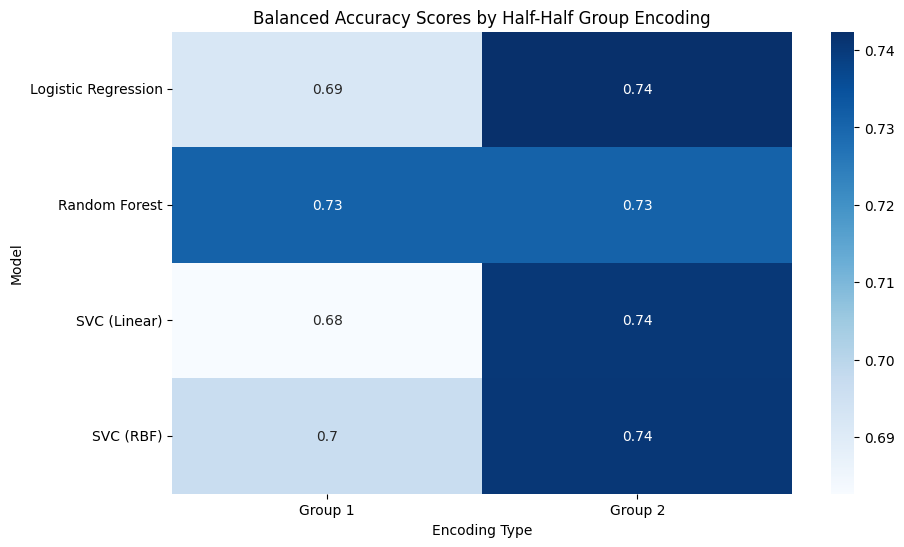

In [17]:
heatmap_data = grouped_half.pivot("model", "oh", "bal_acc")

# Creating the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

# Adding titles and labels
plt.title('Balanced Accuracy Scores by Half-Half Group Encoding')
plt.ylabel('Model')
plt.xlabel('Encoding Type')